In [1]:
"""
Statistical process control charts to emulate functionality provided by MiniTab
"""

'\nStatistical process control charts to emulate functionality provided by MiniTab\n'

In [2]:
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
#import matplotlib.table as tbl
import matplotlib.gridspec as gridspec
import matplotlib.ticker as tkr
%matplotlib inline

In [3]:
def unbias_const(constant, observation):
    '''Moving range unbiasing constant depends on distance between range points. Tabular look up between 0 and 25, calculated between 26 and 100
    ref: http://support.minitab.com/en-us/minitab-express/1/help-and-how-to/control-charts/how-to/variables-data-in-subgroups/xbar-r-chart/methods-and-formulas/unbiasing-constants-d2-d3-and-d4/
    '''
    d2 = [1.128, 1.693, 2.059, 2.326, 2.534, 2.704, 2.847, 2.97, 3.078, 3.173, 3.258, 3.336, 3.407, 3.472, 3.532, 3.588, 3.64, 3.689, 3.735, 3.778, 3.819, 3.858, 3.895, 3.931, 3.964, 3.997, 4.027, 4.057, 4.086, 4.113, 4.139, 4.165, 4.189, 4.213, 4.236, 4.259, 4.28, 4.301, 4.322, 4.341, 4.361, 4.379, 4.398, 4.415, 4.433, 4.45, 4.466, 4.482, 4.498]
    d3 = [0.8525, 0.8884, 0.8798, 0.8641, 0.848, 0.8332, 0.8198, 0.8078, 0.7971, 0.7873, 0.7785, 0.7704, 0.763, 0.7562, 0.7499, 0.7441, 0.7386, 0.7335, 0.7287, 0.7242, 0.7199, 0.7159, 0.7121, 0.7084]
    d4 = [0.954, 1.588, 1.978, 2.257, 2.472, 2.645, 2.791, 2.915, 3.024, 3.121, 3.207, 3.285, 3.356, 3.422, 3.482, 3.538, 3.591, 3.64, 3.686, 3.73, 3.771, 3.811, 3.847, 3.883]
    
    assert constant in ['d2', 'd3', 'd4']
    assert int(observation) <= 100 or int(observation) >= 2
        #raise ValueError('Observation outside of predictable range')
    
    if constant == 'd2' and observation <= 50:
        return d2[observation - 2]
    elif constant == 'd2' and observation > 50:
        return 3.4873 + 0.0250141 * observation - 0.00009823 * observation **2
    if constant == 'd3' and observation <= 25:
        return d3[observation - 2]
    elif constant == 'd3' and observation > 25:
        return 0.80818 - 0.0051871 * observation + 0.00005098 * observation ** 2 - 0.00000019 * observation ** 3
    if constant == 'd4' and observation <= 25:
        return d4[observation - 2]
    elif constant == 'd4' and observation >25:
        return 2.88606 + 0.051313 * observation -0.00049243 * observation ** 2 + 0.00000188 * observation ** 3
    
    '''
    To do: review source material for calculation
    D. J. Wheeler and D. S. Chambers. (1992). Understanding Statistical Process Control, Second Edition, SPC Press, Inc.
    H. Leon Harter (1960). "Tables of Range and Studentized Range". The Annals of Mathematical Statistics, Vol. 31, No. 4, Institute of Mathematical Statistics, 1122−1147.
    '''
    
    

In [4]:
class ControlChart():
    '''
    Tests for special cause
    ruleset invesigation inspired by Michal Nowikowski <godfryd@gmail.com>
    '''
    tests = {
        0: "1 point > n standard deviations from centerline",
        1: "n points in a row on same side of centerline",
        2: "n points in a row, all increasing or all decreasing",
        3: "n points in a row, alternating up and down",
        4: "n of n+1 > 2 standard deviations from center line on same side",
        5: "n of n+1 > 1 standard deviations from center line on same side",
        6: "n points in a row within 1 standard deviation of centerline on either side",
        7: "n points in a row greater than 1 standard deviation from centerline on either side"
        }
    def __init__(self
                 , data
                 , *args
                 , spec_max = None
                 , spec_min = None
                 #, index = 0
                 , sigma_level = 3
                 , on_same_side = 9
                 , trending = 6
                 , alternating = 14
                 , beyond_2sigma = 2
                 , beyond_1sigma = 4
                 , within_1sigma = 15
                 , outside_1sigma = 8
                 , test_group = None
                 , **kwargs
                ):
        self.data = pd.DataFrame(data)
        self.usl = spec_max
        self.lsl = spec_min
        self.sigma_level = sigma_level
        self.on_same_side  = on_same_side 
        self.trending = trending
        self.alternating = alternating
        self.beyond_2sigma = beyond_2sigma
        self.beyond_1sigma = beyond_1sigma
        self.within_1sigma = within_1sigma
        self.outside_1sigma = outside_1sigma
        self.test_group = test_group
        #self.index = index #amount to shift output dataframe index by
    
    def _test_list(self):
        self.test_list = self.test_group if self.test_group else []
        test_matrix = pd.DataFrame(index = range(len(self.data.index)))
        for i in self.test_list:
            test_matrix[i] = {
                0: self._test0_run,
                1: self._test1_run,
                2: self._test2_run,
                3: self._test3_run,
                4: self._test4_run,
                5: self._test5_run,
                6: self._test6_run,
                7: self._test7_run
            }[i]()
        self.failures = self.data[test_matrix.any(axis = 1)]
        
        '''lists of popular groupings    
        RULES_BASIC = [RULES_1_BEYOND_3SIGMA, 
                       RULES_7_ON_ONE_SIDE]
        RULES_PMI = [RULES_1_BEYOND_3SIGMA,
                     RULES_8_ON_ONE_SIDE]
        RULES_WECO = [RULES_1_BEYOND_3SIGMA,
                      RULES_2_OF_3_BEYOND_2SIGMA, 
                      RULES_4_OF_5_BEYOND_1SIGMA, 
                      RULES_8_ON_ONE_SIDE,
                      RULES_6_TRENDING, RULES_14_UP_DOWN]
        RULES_NELSON = [RULES_1_BEYOND_3SIGMA,
                        RULES_9_ON_ONE_SIDE,
                        RULES_6_TRENDING,
                        RULES_14_UP_DOWN,
                        RULES_2_OF_3_BEYOND_2SIGMA,
                        RULES_4_OF_5_BEYOND_1SIGMA,
                        RULES_15_BELOW_1SIGMA,
                        RULES_8_BEYOND_1SIGMA_BOTH_SIDES]

        RULES_ALL = [RULES_1_BEYOND_3SIGMA,
                     RULES_2_OF_3_BEYOND_2SIGMA,
                     RULES_4_OF_5_BEYOND_1SIGMA,
                     RULES_7_ON_ONE_SIDE,
                     RULES_8_ON_ONE_SIDE,
                     RULES_6_TRENDING,
                     RULES_14_UP_DOWN,
                     RULES_15_BELOW_1SIGMA,
                     RULES_8_BEYOND_1SIGMA_BOTH_SIDES]
        '''
    def _test_spec_run(self):
        if self.usl:
            above = self.data > self.usl
            self.usl_array = np.full(len(self.data.index), self.usl, dtype=np.float64)
        else:
            above = pd.DataFrame([False] * len(self.data.index))
        if self.lsl:
            below = self.data < self.lsl
            self.lsl_array = np.full(len(self.data.index), self.lsl, dtype=np.float64)
        else:
            below = pd.DataFrame([False] * len(self.data.index))
        self.out_of_spec = self.data[above | below]
        
        if self.usl or self.lsl: self._cpk_calc()
    
    def _cpk_calc(self):
        #Calc CPU
        try:
            cpu = (self.usl - self.centerline) / 3 / self.stddev
        except TypeError:
            cpu = False
        #Calc CPL
        try:
            cpl = (self.centerline - self.lsl) / 3 / self.stddev
        except TypeError:
            cpl = False
        #Take min of existing
        if cpu and cpl:
            self.cpk = min(cpu, cpl)
        elif cpu and not cpl:
            self.cpk = cpu
        elif not cpu and cpl:
            self.cpk = cpl
            
    def _test0_run(self):
        "1 point > n standard deviations from centerline, returns True if out"
        above = self.data > (self.centerline + self.sigma_level * self.stddev)
        below = self.data < (self.centerline - self.sigma_level * self.stddev)
        return above | below
    def _test1_run(self):
        return [False] * len(self.data.index)
    def _test2_run(self):
        return [False] * len(self.data.index)
    def _test3_run(self):
        return [False] * len(self.data.index)
    def _test4_run(self):
        return [False] * len(self.data.index)
    def _test5_run(self):
        return [False] * len(self.data.index)
    def _test6_run(self):
        return [False] * len(self.data.index)
    def _test7_run(self):
        return [False] * len(self.data.index)
    '''tests = {
        0: [_test0_run(), "1 point > n standard deviations from centerline"],
        1: [_test1_run(), "n points in a row on same side of centerline"],
        2: [_test2_run(), "n points in a row, all increasing or all decreasing"],
        3: [_test3_run(), "n points in a row, alternating up and down"],
        4: [_test4_run(), "n of n+1 > 2 standard deviations from center line on same side"],
        5: [_test5_run(), "n of n+1 > 1 standard deviations from center line on same side"],
        6: [_test6_run(), "n points in a row within 1 standard deviation of centerline on either side"],
        7: [_test7_run(), "n points in a row greater than 1 standard deviation from centerline on either side"]
    }'''
    def get_plot_arrays(self):
        '''Returns numpy arrays for individual data, center line value, upper and lower control limits, upper and lower spec limits, as applicable'''
        plots = {'pts': np.array(self.data[0]),
                'cen': self.centerline_array,
                'lcl': self.lcl_array,
                'ucl': self.ucl_array
                }
        if self.usl: plots['usl'] = self.usl_array
        if self.lsl: plots['lsl'] = self.lsl_array
        return plots

In [5]:
class MovingRange(ControlChart):
    '''
    Generates Shewhart moving range control chart data, from positional element data, including approximate sigma. Plot using other packages
    observation range, how large of a subset to review range of; default 2
    sigma_level, test for special cause 1 rejection level; default 3
    '''
    
    def __init__(self, *args, observation_range = 2, stddev_only = False, **kwargs):
        super(MovingRange, self).__init__(*args, **kwargs)
        self.observation_range = observation_range
        self._moving_range_array()
        #self._moving_range_median() if use_median else self._moving_range_mean()
        self._mean()
        self._stddev()
        if not stddev_only:
            self._centerline()
            self._lcl()
            self._ucl()
            self._test_list()
            self._test_spec_run()
        #print('sigma level Moving range', self.sigma_level)
        
    def _moving_range_array(self):
        '''Generate an array from the moving average for the given observation range. Overwrites input data, for Class consistancy.
        Need to perform time study to determine if this method or if building comparison method is faster'''
        #if self.observation_range == 2:
        #    #signed_array = (self.data - np.roll(self.data,1))[1:]
        #    #self.moving_range_array = np.array([abs(i) for i in signed_array])
        #    print(self.data.head(), self.data.shift(periods=1).head())
        #    self.moving_range_array = pd.DataFrame((self.data - np.roll(self.data, 1))[1:]).abs()
        #else:
        mr = []
        for i in range(len(self.data.index) - self.observation_range + 1):
            subset = data[i:i + self.observation_range]
            mr = mr + [max(subset) - min(subset)]
        self.data = pd.DataFrame(mr) # np.array(mr)
                
    def _mean(self):
        self.mean = self.data.mean()[0] #get value only
    #def _median(self):
    #unable to achieve same stats using this method. More investigation necessary. MR-Bar not the same
    #    self.centerline = self.data.median
    
    def _stddev(self):
        self.stddev = self.mean / unbias_const('d2', self.observation_range)
        
    def _centerline(self, index = 0):
        self.centerline = self.mean
        self.centerline_array = np.full(len(self.data.index), self.centerline, dtype=np.float64)
    
    def _lcl(self):
        lcl = self.mean - self.sigma_level * unbias_const('d3', self.observation_range) * self.stddev
        self.lcl = max(0, lcl) 
        self.lcl_array = np.full(len(self.data.index), self.lcl, dtype=np.float64)
        
    def _ucl(self):
        self.ucl = self.mean + self.sigma_level * unbias_const('d3', self.observation_range) * self.stddev
        self.ucl_array = np.full(len(self.data.index), self.ucl, dtype=np.float64)

    def get_S(self):
        return self.stddev

In [6]:
class Individual(ControlChart):
    '''
    Generates plot data for base indvidual data. Accepts modifications to mean, stdev, UCL & LCL for historical comparison.
    observation range, how large of a subset to review range of, only applicable to moving range sub calculation; default 2
    sigma_level, test for special cause 1 rejection level; default 3
    '''
    def __init__(self, *args, process_mean = None, stddev = None, observation_range = 2, **kwargs):
        super(Individual, self).__init__(*args, **kwargs)
        self.observation_range = observation_range
        self._mean(process_mean)
        self.stddev = stddev if stddev else self.get_S()
        self._centerline()
        self._lcl()
        self._ucl()
        self._test_list()
        self._test_spec_run()
        self._ADnormality()
                
    def _mean(self, process_mean):
        self.mean = process_mean if process_mean else self.data.mean()[0]
    
    def _centerline(self):
        self.centerline = self.mean #add future use of median if necessary
        self.centerline_array = np.full(len(self.data.index), self.centerline, dtype=np.float64)
        
    def _lcl(self):
        self.lcl = self.centerline - self.sigma_level * self.stddev
        self.lcl_array = np.full(len(self.data.index), self.lcl, dtype=np.float64)
        
    def _ucl(self):
        self.ucl = self.centerline + self.sigma_level * self.stddev
        self.ucl_array = np.full(len(self.data.index), self.ucl, dtype=np.float64)
    
    def get_S(self):
        mr = MovingRange(data, observation_range = self.observation_range, sigma_level = self.sigma_level, stddev_only = True)
        S = mr.get_S()
        del mr
        return S
    
    def _ADnormality(self):
        self.ADnorm, crit, sig_lvl = scipy.stats.anderson(self.data[0])
    

In [7]:
#data = np.random.uniform(0,20, size=50)
#data
data = np.array([  9.34999539,  12.29553633,  12.87716269,  11.65116755,
        18.98766129,  14.89768108,   4.45505896,  19.57145657,
         7.52852306,   5.48842305,  14.14715662,   3.6559823 ,
        16.63975782,  10.64982489,   0.61429544,  14.96361784,
         0.22892579,   6.13441891,  10.84772921,  19.07766444,
        12.72143363,   7.9632271 ,  15.84851199,  16.20706673,
         5.80264562,  11.26969106,   3.58238806,  18.98077966,
        10.29094826,  11.94137679,   1.00168845,  13.94550104,
        15.52215851,   4.11266406,  18.52735388,  10.87532306,
        10.93046787,   1.94403835,  14.76091577,   5.91899053,
         1.0619265 ,  14.54814162,   3.74159438,   8.73187924,
         7.04287383,   1.80945405,  12.09787963,   8.93307862,
         3.49060659,   9.07306645])
#data_norm = np.random.normal(loc = 10, scale = 3, size = 50)
data_norm = np.array([  9.66616659,  12.4342637 ,   8.45095659,  10.85332184,
        11.43697209,   5.44923774,  11.87099339,   9.26025353,
        12.53468816,  13.472874  ,   9.32427283,   5.50494739,
        10.49917369,   9.57117766,   9.1981797 ,  10.11596433,
         8.02700409,   5.84405743,  12.2946844 ,   7.4435819 ,
         8.73284983,   7.66242993,   8.53742508,  10.31176123,
        12.24060411,  11.36681105,  10.75544841,   9.34431126,
        11.94722901,  11.14027774,  15.01253089,   7.41545096,
        10.40742079,  13.66156747,   8.40089713,  11.69334343,
         8.07830053,   8.75013972,   7.94911513,   9.8885315 ,
        13.85713166,  12.95029577,  14.84414927,  10.25618316,
        11.68127781,   5.9678435 ,  13.94221598,  12.26473954,
         9.7867028 ,   8.22603327])

In [ ]:
data2 = pd.DataFrame(data)
mr2 = MovingRange(data2, test_group =[0])
ind2 = Individual(data2, stddev = mr2.get_S(), test_group = [0], spec_max = 15, spec_min = 6)
mr2_df = pd.DataFrame.from_dict(mr2.get_plot_arrays())
ind2_df = pd.DataFrame.from_dict(ind2.get_plot_arrays())

#formatting calls
fmt_pts  = {'color': 'black', 'linestyle': 'solid', 'marker': 's'} #data
fmt_fail = {'color': 'green', 'linestyle': None,    'marker': 's'} #failed points
fmt_spec = {'color': 'red',   'linestyle': None,    'marker': 's'} #out_of_spec
fmt_cen  = {'color': 'green', 'linestyle': 'dashed', 'marker': None} #centerlines
fmt_cl   = {'color': 'green', 'linestyle': 'solid', 'marker': None} #control limits
fmt_sl   = {'color': 'red',   'linestyle': 'solid', 'marker': None} #spec limits

# set x variables
ind2_x = np.arange(0, len(ind2_df.index), 1)
mr2_x = np.arange(0, len(mr2_df.index), 1)

plt.close('all') #clean memory space
ylabel = 'Strength (Ksi)'
gs = gridspec.GridSpec(2, 2,
                       width_ratios=[1,3],
                       height_ratios=[5,3]
                       )
plt.figure(1, figsize=(10,10))

#Individual plot
ax1 = plt.subplot(gs[1])
plt.plot(ind2_x, ind2_df['lcl'], **fmt_cl)
plt.plot(ind2_x, ind2_df['ucl'], **fmt_cl)
plt.plot(ind2_x, ind2_df['lsl'], **fmt_sl)
plt.plot(ind2_x, ind2_df['usl'], **fmt_sl)
plt.plot(ind2_x, ind2_df['cen'], **fmt_cen)
plt.plot(ind2_x, ind2_df['pts'], **fmt_pts)
plt.plot(ind2.failures, **fmt_fail)
plt.plot(ind2.out_of_spec, **fmt_spec)
plt.title('Individual')
plt.ylabel(ylabel)

#Moving Range plot
ax3 = plt.subplot(gs[3])
plt.plot(mr2_x, mr2_df['lcl'], **fmt_cl)
plt.plot(mr2_x, mr2_df['ucl'], **fmt_cl)
plt.plot(mr2_x, mr2_df['cen'], **fmt_cen)
plt.plot(mr2_x, mr2_df['pts'], **fmt_pts)
plt.plot(mr2.failures, **fmt_fail)
plt.title('Moving Range')
plt.ylabel(ylabel)

#histogram of individual
ax0 = plt.subplot(gs[0], sharey = ax1)
plt.hist(data2, 10, normed=1, orientation= 'horizontal', color = 'orange')
x_array = np.linspace(*ax1.get_ylim(), num = 50)
y = mlab.normpdf(x_array, ind2.mean, ind2.stddev)
plt.plot(y, x_array, **fmt_cen)

plt.axhline(y=ind2.lsl, **fmt_sl)
plt.axhline(y=ind2.usl, **fmt_sl)
plt.ylabel(ylabel)
formatter = tkr.FormatStrFormatter('%1.2f')
plt.gca().invert_xaxis()

#Space for results
ax2 = plt.subplot(gs[2])
plt.axis('off')
text = '\
centerline: {:1.4g}\n\
Std Dev: {:1.4f}\n\
UCL: {:1.4g} LCL: {:1.4g}\n\
USL: {:1.4g} LSL: {:1.4g}\n\
CPk: {:1.4g}\n\
Normality: \n'.format(ind2.mean, ind2.stddev, ind2.ucl, ind2.lcl, ind2.usl, ind2.lsl, ind2.cpk)
print(text)
plt.text(0.0, 0.5, text)
#tbl_text = [ ['cpk', ind2.cpk]]
#table = tbl.table(ax2, tbl_text)


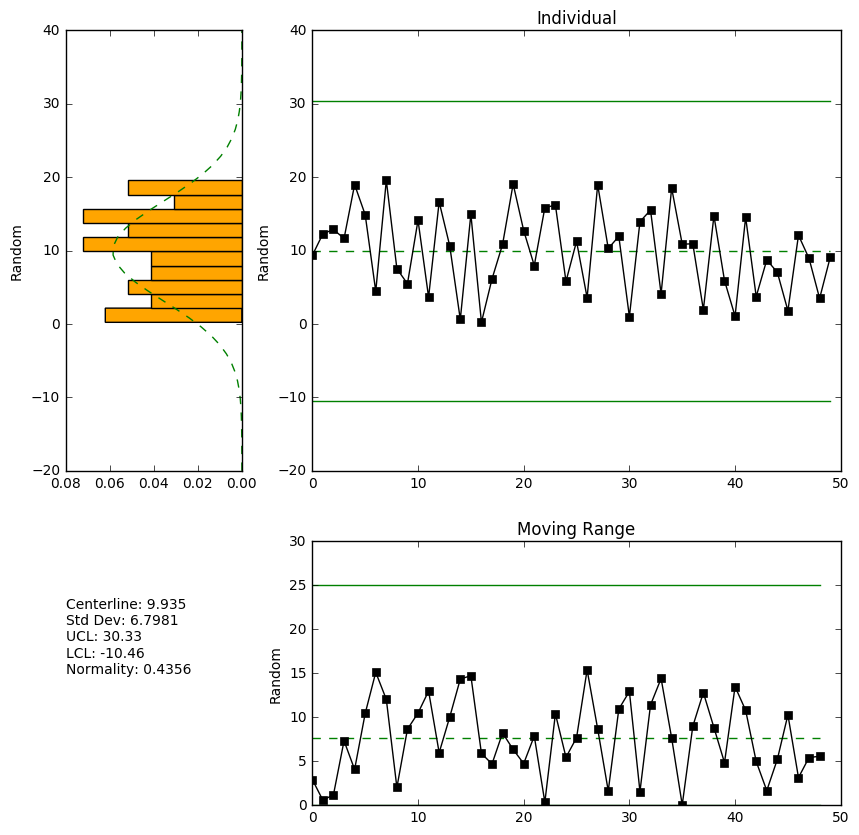

In [43]:
class ControlChartFigureWrapper():
    
    #formatting defaults
    fmt_pts  = {'color': 'black', 'linestyle': 'solid', 'marker': 's'} #data
    fmt_fail = {'color': 'green', 'linestyle': None,    'marker': 's'} #failed points
    fmt_spec = {'color': 'red',   'linestyle': None,    'marker': 's'} #out_of_spec
    fmt_cen  = {'color': 'green', 'linestyle': 'dashed', 'marker': None} #centerlines
    fmt_cl   = {'color': 'green', 'linestyle': 'solid', 'marker': None} #control limits
    fmt_sl   = {'color': 'red',   'linestyle': 'solid', 'marker': None} #spec limits
    
    stats = {'centerline': True, 'stddev': True, 'ucl': True, 'lcl': True, 'usl': False, 'lsl': False, 'cpk': False,
            'A-D normality': False
            }
    def __init__(self, data, charts = 'H-I-MR', *args, **kwargs):
        self.data = data
        #plt.close('all')
      
        #try: ylabel = kwarg.pop('ylabel')
        #except: ylabel = ''
        figsize = kwargs.get('figsize', (10,10))
        self.charts = charts
        self.fmt_pts.update(kwargs.get('fmt_pts', {}))
        self.fmt_fail.update(kwargs.get('fmt_fail', {}))
        self.fmt_spec.update(kwargs.get('fmt_spec', {}))
        self.fmt_cen.update(kwargs.get('fmt_cen', {}))
        self.fmt_cl.update(kwargs.get('fmt_cl', {}))
        self.fmt_sl.update(kwargs.get('fmt_sl', {}))
        self.stats.update(kwargs.get('stats', {}))
        {
            'H-I-MR': self._figure_HIMR,
            'I': self._figure_Individual,
            'I-MR': self._figure_IMR
            #'XR'
            #'XS'
            #'H'
        }[charts](figsize = figsize, *args, **kwargs)

        
    def _figure_HIMR(self, figsize, *args, **kwargs):
        self.gs = gridspec.GridSpec(2, 2,
                       width_ratios=[1,3],
                       height_ratios=[5,3]
                       )
        plt.figure(1, figsize=figsize)
        self._plot_mr(*args, gs_pos = 3, **kwargs)
        self._plot_individual(*args, gs_pos = 1, stddev = self.mr.stddev, **kwargs)
        self._plot_hist(*args, gs_pos = 0, **kwargs)
        self._plot_stats(*args, gs_pos = 2, **kwargs)
        
    def _figure_Individual(self, figsize, *args, **kwargs):
        self.gs = gridspec.GridSpec(1,1)
        
        plt.figure(2, figsize=figsize)
        self._plot_individual(*args, gs_pos = 0, **kwargs)
    
    def _figure_IMR(self, figsize, *args, **kwargs):
        self.gs = gridspec.GridSpec(2, 1,
                       height_ratios=[5,3]
                       )
        plt.figure(3, figsize=figsize)
        self._plot_mr(*args, gs_pos = 1, **kwargs)
        self._plot_individual(*args, gs_pos = 0, stddev = self.mr.stddev, **kwargs)
        
    def _plot_individual(self, gs_pos, *args, **kwargs):
        #Initialize plot, grab kwargs
        spec_min = kwargs.get('spec_min', False)
        spec_max = kwargs.get('spec_max', False)
        ylabel = kwargs.get('ylabel', False)
        
        self.ind = Individual(self.data, *args, **kwargs)
                
        ind_df = pd.DataFrame.from_dict(self.ind.get_plot_arrays())
        ind_x = np.arange(0, len(ind_df.index), 1)

        self.ind_axes = plt.subplot(self.gs[gs_pos])
        plt.plot(ind_x, ind_df['lcl'], **self.fmt_cl)
        plt.plot(ind_x, ind_df['ucl'], **self.fmt_cl)
        if spec_min:
            plt.plot(ind_x, ind_df['lsl'], **self.fmt_sl)
        if spec_max:
            plt.plot(ind_x, ind_df['usl'], **self.fmt_sl)
        plt.plot(ind_x, ind_df['cen'], **self.fmt_cen)
        plt.plot(ind_x, ind_df['pts'], **self.fmt_pts)
        plt.plot(self.ind.failures, **self.fmt_fail)
        plt.plot(self.ind.out_of_spec, **self.fmt_spec)
        plt.title('Individual')
        if ylabel:
            plt.ylabel(ylabel)
    
    def _plot_mr(self, *args, gs_pos, **kwargs):
        #Initialize plot, grab kwargs
        ylabel = kwargs.get('ylabel', False)

        self.mr = MovingRange(self.data, *args, **kwargs)
        mr_df = pd.DataFrame.from_dict(self.mr.get_plot_arrays())
        mr_x = np.arange(0, len(mr_df.index), 1)

        plt.subplot(self.gs[gs_pos])
        plt.plot(mr_x, mr_df['lcl'], **self.fmt_cl)
        plt.plot(mr_x, mr_df['ucl'], **self.fmt_cl)
        plt.plot(mr_x, mr_df['cen'], **self.fmt_cen)
        plt.plot(mr_x, mr_df['pts'], **self.fmt_pts)
        plt.plot(self.mr.failures, **self.fmt_fail)
        plt.title('Moving Range')
        if ylabel:
            plt.ylabel(ylabel)
    
    def _plot_hist(self, *args, gs_pos, num_bins = 10, orientation = 'horizontal', **kwargs):
        #Initialize plot, grab kwargs
        spec_min = kwargs.get('spec_min', False)
        spec_max = kwargs.get('spec_max', False)
        ylabel = kwargs.get('ylabel', False)
        #charts = kwargs.get('charts', 'H-I-MR')
        
        if self.charts == 'H-I-MR':
            self.hist_axes = plt.subplot(self.gs[gs_pos], sharey = self.ind_axes)
            plt.hist(self.data, num_bins, normed=1, orientation = orientation, color = 'orange')
            x_array = np.linspace(*self.hist_axes.get_ylim(), num = 50)
            y = mlab.normpdf(x_array, self.ind.mean, self.ind.stddev)
            plt.plot(y, x_array, **self.fmt_cen)
            
            plt.xticks(np.linspace(*self.hist_axes.get_xlim(), num = 5) )
            if spec_min:
                plt.axhline(y=ind.lsl, **self.fmt_sl)
            if spec_max:
                plt.axhline(y=ind.usl, **self.fmt_sl)
            if ylabel:
                plt.ylabel(ylabel)
            formatter = tkr.FormatStrFormatter('%1.2f')
            self.hist_axes.xaxis.set_major_formatter(formatter)
            plt.gca().invert_xaxis()
        else:
            self.hist_axes = plt.subplot(gs[gs_pos])
        
    def _plot_stats(self, *args, gs_pos, **kwargs):
        plt.subplot(self.gs[gs_pos])
        plt.axis('off')
        stat_result = []
        if self.stats['centerline']: stat_result.append('Centerline: {:1.4g}'.format(self.ind.mean))
        if self.stats['stddev']: stat_result.append('Std Dev: {:1.4f}'.format(self.ind.stddev))
        if self.stats['ucl']: stat_result.append('UCL: {:1.4g}'.format(self.ind.ucl)) 
        if self.stats['lcl']: stat_result.append('LCL: {:1.4g}'.format(self.ind.lcl))
        if self.stats['usl']: stat_result.append('USL: {:1.4g}'.format(self.ind.usl))
        if self.stats['lsl']: stat_result.append('LSL: {:1.4g}'.format(self.ind.lsl))
        if self.stats['cpk']: stat_result.append('CPk: {:1.4g}'.format(self.ind.cpk))
        if self.stats['A-D normality']: stat_result.append('Normality: {:1.4g}'.format(self.ind.ADnorm))
        plt.text(0.0, 0.5, '\n'.join(stat_result))
        
#unit test?
data_df = pd.DataFrame(data)
stats = {'centerline': True, 'stddev': True, 'ucl': True, 'lcl': True, 'usl': False, 'lsl': False, 'cpk': False,
            'A-D normality': True
            }
ControlChartFigureWrapper(data_df, charts = 'H-I-MR', ylabel = 'Random', stats = stats)


HIMR selected
Plotting MR
Plotting individual
plotting hist
plotting stats
Individual selected
Plotting individual
IMR selected
Plotting MR
Plotting individual


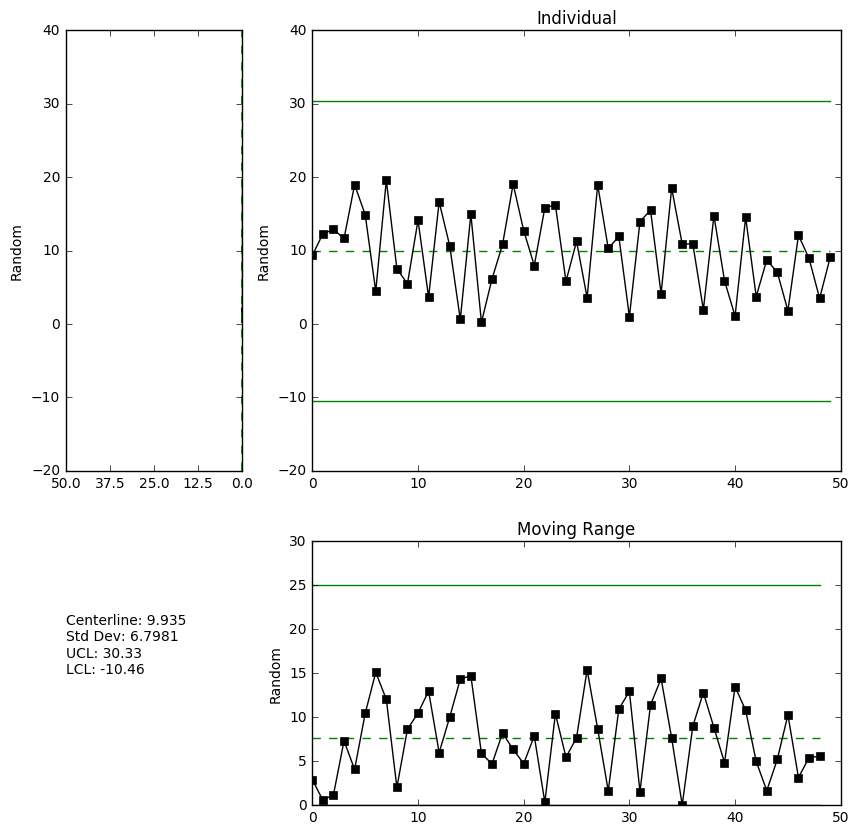

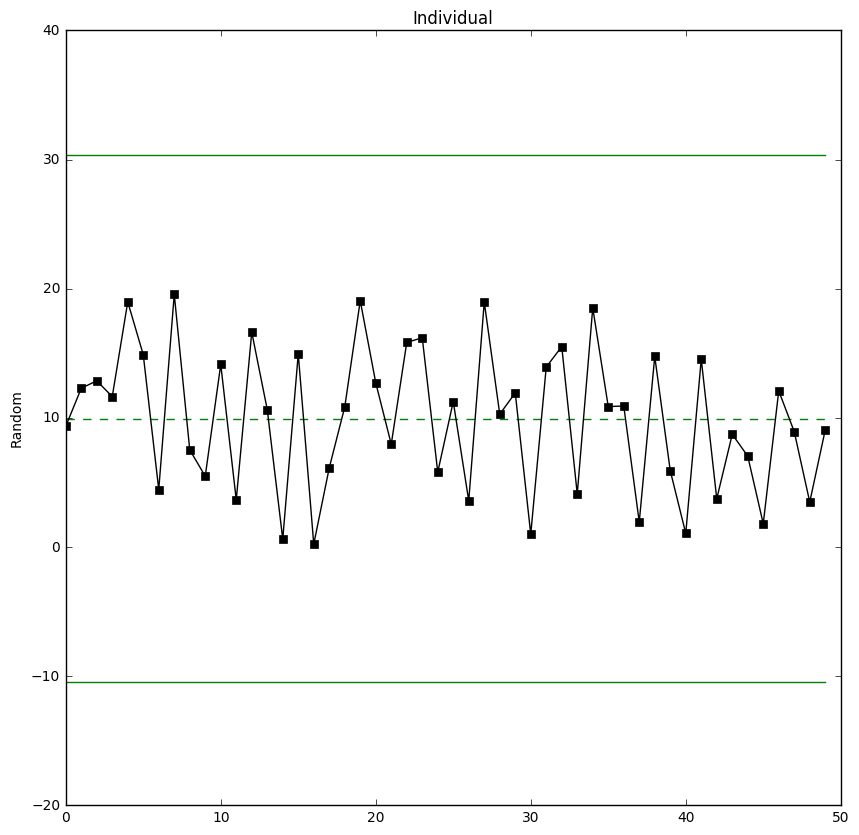

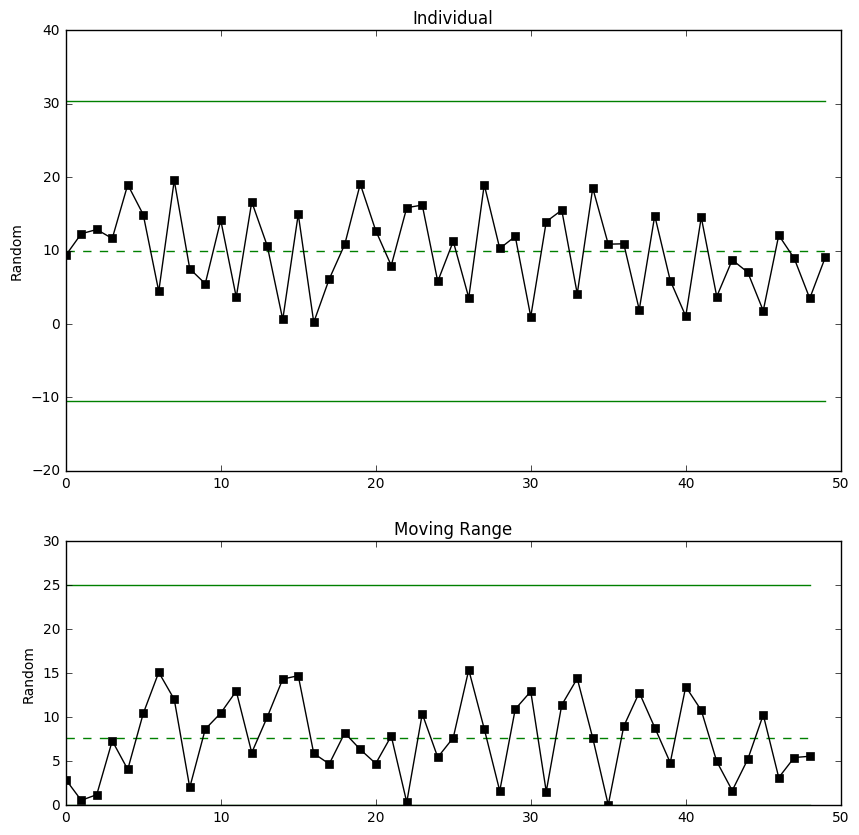

"""
SPC Statistical Process Control provides means to monitor process behaviour
using statistical tools defined by Shewhart and others. The process run is shown
as Quality Control Charts (QCC).

Author: Michal Nowikowski <godfryd@gmail.com>

License: MIT
"""

import numpy as np


CHART_X_BAR_R_X = "x_bar R - X"
CHART_X_BAR_R_R = "x_bar R - R"
CHART_X_BAR_S_X = "x_bar S - X"
CHART_X_BAR_S_S = "x_bar S - S"
CHART_X_MR_X = "X mR - X"
CHART_X_MR_MR = "X mR - mR"
CHART_P = "p"
CHART_NP = "np"
CHART_C = "c"
CHART_U = "u"
CHART_EWMA = "EWMA"
CHART_CUSUM = "CUSUM"
CHART_THREE_WAY = "three way"
CHART_TIME_SERIES = "time series"

RULES_1_BEYOND_3SIGMA = "1 beyond 3*sigma"
RULES_2_OF_3_BEYOND_2SIGMA = "2 of 3 beyond 2*sigma"
RULES_4_OF_5_BEYOND_1SIGMA = "4 of 5 beyond 1*sigma"
RULES_7_ON_ONE_SIDE = "7 on one side"
RULES_8_ON_ONE_SIDE = "8 on one side"
RULES_9_ON_ONE_SIDE = "9 on one side"
RULES_6_TRENDING = "6 trending"
RULES_14_UP_DOWN = "14 up down"
RULES_15_BELOW_1SIGMA = "15 below 1*sigma"
RULES_8_BEYOND_1SIGMA_BOTH_SIDES = "8 beyond 1*sigma on both sides"

RULES_BASIC = [RULES_1_BEYOND_3SIGMA, 
               RULES_7_ON_ONE_SIDE]
RULES_PMI = [RULES_1_BEYOND_3SIGMA,
             RULES_8_ON_ONE_SIDE]
RULES_WECO = [RULES_1_BEYOND_3SIGMA,
              RULES_2_OF_3_BEYOND_2SIGMA, 
              RULES_4_OF_5_BEYOND_1SIGMA, 
              RULES_8_ON_ONE_SIDE,
              RULES_6_TRENDING, RULES_14_UP_DOWN]
RULES_NELSON = [RULES_1_BEYOND_3SIGMA,
                RULES_9_ON_ONE_SIDE,
                RULES_6_TRENDING,
                RULES_14_UP_DOWN,
                RULES_2_OF_3_BEYOND_2SIGMA,
                RULES_4_OF_5_BEYOND_1SIGMA,
                RULES_15_BELOW_1SIGMA,
                RULES_8_BEYOND_1SIGMA_BOTH_SIDES]

RULES_ALL = [RULES_1_BEYOND_3SIGMA,
             RULES_2_OF_3_BEYOND_2SIGMA,
             RULES_4_OF_5_BEYOND_1SIGMA,
             RULES_7_ON_ONE_SIDE,
             RULES_8_ON_ONE_SIDE,
             RULES_6_TRENDING,
             RULES_14_UP_DOWN,
             RULES_15_BELOW_1SIGMA,
             RULES_8_BEYOND_1SIGMA_BOTH_SIDES]


def test_beyond_limits(data, center, lcl, ucl):
    return data[0] > ucl or data[0] < lcl


def test_violating_runs(data, center, lcl, ucl):
    for i in xrange(1, len(data)):
        if (data[i-1] - center)*(data[i] - center) < 0:
            return False
    return True

# n         2      3      4      5      6      7      8      9      10
A2 = [0, 0, 1.880, 1.023, 0.729, 0.577, 0.483, 0.419, 0.373, 0.337, 0.308]
D3 = [0, 0, 0, 0, 0, 0, 0, 0.076, 0.136, 0.184, 0.223]
D4 = [0, 0, 3.267, 2.575, 2.282, 2.115, 2.004, 1.924, 1.864, 1.816, 1.777]
# n   0 1      2      3      4      5      6      7      8      9     10     
# 11     12     13     14     15       20     25
c4 = [0, 0, 0.7979, 0.8862, 0.9213, 0.9400, 0.9515, 0.9594, 0.9650, 
      0.9693, 0.9727, 0.9754, 0.9776, 0.9794, 0.9810, 0.9823]  # 0.9869, 0.9896]
B3 = [0, 0, 0, 0, 0, 0, 0.030, 0.118, 0.185, 0.239, 0.284, 0.321, 
      0.354, 0.382, 0.406, 0.428]  # 0.510, 0.565]
B4 = [0, 0, 3.267, 2.568, 2.266, 2.089, 1.970, 1.882, 1.815, 1.761, 
      1.716, 1.679, 1.646, 1.618, 1.594, 1.572]  # 1.490, 1.435]
B5 = [0, 0, 0, 0, 0, 0, 0.029, 0.113, 0.179, 0.232, 0.276, 0.313, 
      0.346, 0.374, 0.399, 0.421]  # 0.504, 0.559]
B6 = [0, 0, 2.606, 2.276, 2.088, 1.964, 1.874, 1.806, 1.751, 1.707, 
      1.669, 1.637, 1.610, 1.585, 1.563, 1.544]  # 1.470, 1.420]
A3 = [0, 0, 2.659, 1.954, 1.628, 1.427, 1.287, 1.182, 1.099, 1.032, 
      0.975, 0.927, 0.886, 0.850, 0.817, 0.789]  # 0.680, 0.606]


def get_stats_x_mr_x(data, size):
    assert size == 1
    center = np.mean(data)
    sd = 0
    for i in xrange(len(data)-1):
        sd += abs(data[i] - data[i+1])
    sd /= len(data) - 1
    d2 = 1.128
    lcl = center - 3*sd/d2
    ucl = center + 3*sd/d2
    return center, lcl, ucl


def get_stats_x_mr_mr(data, size):
    assert size == 1
    sd = 0
    for i in xrange(len(data)-1):
        sd += abs(data[i] - data[i+1])
    sd /= len(data) - 1
    d2 = 1.128
    center = sd
    lcl = 0
    ucl = center + 3*sd/d2
    return center, lcl, ucl


def get_stats_x_bar_r_x(data, size):
    n = size
    assert n >= 2
    assert n <= 10

    r_sum = 0
    for xset in data:
        assert len(xset) == n
        r_sum += max(xset) - min(xset)
    r_bar = r_sum / len(data)

    x_bar = np.mean(data)

    center = x_bar
    lcl = center - A2[n]*r_bar
    ucl = center + A2[n]*r_bar
    return center, lcl, ucl


def get_stats_x_bar_r_r(data, size):
    n = size
    assert n >= 2
    assert n <= 10

    r_sum = 0
    for xset in data:
        assert len(xset) == n
        r_sum += max(xset) - min(xset)
    r_bar = r_sum / len(data)

    center = r_bar
    lcl = D3[n]*r_bar
    ucl = D4[n]*r_bar
    return center, lcl, ucl


def get_stats_x_bar_s_x(data, size):
    n = size
    assert n >= 2
    assert n <= 10

    s_bar = np.mean(np.std(data, 1, ddof=1))
    x_bar = np.mean(data)

    center = x_bar
    lcl = center - A3[n]*s_bar
    ucl = center + A3[n]*s_bar
    return center, lcl, ucl


def get_stats_x_bar_s_s(data, size):
    n = size
    assert n >= 2
    assert n <= 10

    s_bar = np.mean(np.std(data, 1, ddof=1))

    center = s_bar
    lcl = B3[n]*s_bar
    ucl = B4[n]*s_bar
    return center, lcl, ucl


def get_stats_p(data, size):
    n = size
    assert n > 1

    pbar = float(sum(data)) / (n * len(data))
    sd = np.sqrt(pbar*(1-pbar)/n)

    center = pbar
    lcl = center - 3*sd
    if lcl < 0:
        lcl = 0
    ucl = center + 3*sd
    if ucl > 1:
        ucl = 1.0
    return center, lcl, ucl


def get_stats_np(data, size):
    n = size
    assert n > 1

    pbar = float(sum(data)) / (n * len(data))
    sd = np.sqrt(n*pbar*(1-pbar))

    center = n*pbar
    lcl = center - 3*sd
    if lcl < 0:
        lcl = 0
    ucl = center + 3*sd
    if ucl > n:
        ucl = n
    return center, lcl, ucl


def get_stats_c(data, size):
    cbar = np.mean(data)

    center = cbar
    lcl = center - 3*np.sqrt(cbar)
    if lcl < 0:
        lcl = 0
    ucl = center + 3*np.sqrt(cbar)
    return center, lcl, ucl


def get_stats_u(data, size):
    n = size
    assert n > 1

    cbar = float(sum(data))/(len(data)*n)

    center = cbar
    lcl = center - 3*np.sqrt(cbar/n)
    if lcl < 0:
        lcl = 0
    ucl = center + 3*np.sqrt(cbar/n)
    return center, lcl, ucl


def get_stats_cusum(data, size):
    """
    Find the data for a cusum graph

    Only returns 0 as the center as the data is moved 
    its mean and ucl and lcl are not reported
    """ 
    return 0, None, None


def prepare_data_none(data, size):
    return data


def prepare_data_x_bar_rs_x(data, size):
    data2 = []
    for xset in data:
        data2.append(np.mean(xset))
    return data2


def prepare_data_x_bar_r_r(data, size):
    data2 = []
    for xset in data:
        data2.append(max(xset) - min(xset))
    return data2


def prepare_data_x_bar_s_s(data, size):
    data2 = []
    for xset in data:
        data2.append(np.std(xset, ddof=1))
    return data2


def prepare_data_x_mr(data, size):
    data2 = [0]
    for i in xrange(len(data)-1):
        data2.append(abs(data[i] - data[i+1]))
    return data2


def prepare_data_p(data, size):
    data2 = [0]
    for d in data:
        data2.append(float(d)/size)
    return data2


def prepare_data_u(data, size):
    data2 = [0]
    for d in data:
        data2.append(float(d)/size)
    return data2


def prepare_data_cusum(data, size, target=None):
    """
    Prepares the data for a CUSUM graph

    subtracts the mean from each data point
    then calculates the culumative sum of each
    $S_m=\sum_{i=1}^m (x_i-\mu)$
    where $x_i$ is the data point
    $\mu$ is the target value

    if $\mu is not provided the mean of the sample is used
    """
    data2 = []
    if target is None:
        target = np.mean(data)
    for d in data:
        data2.append(float(d) - target)
    data3 = [sum(data2[:i]) for i in xrange(len(data2)+1)]
    return data3

STATS_FUNCS = {
    CHART_X_BAR_R_X: (get_stats_x_bar_r_x, prepare_data_x_bar_rs_x),
    CHART_X_BAR_R_R: (get_stats_x_bar_r_r, prepare_data_x_bar_r_r),
    CHART_X_BAR_S_X: (get_stats_x_bar_s_x, prepare_data_x_bar_rs_x),
    CHART_X_BAR_S_S: (get_stats_x_bar_s_s, prepare_data_x_bar_s_s),
    CHART_X_MR_X: (get_stats_x_mr_x, prepare_data_none),
    CHART_X_MR_MR: (get_stats_x_mr_mr, prepare_data_x_mr),
    CHART_P: (get_stats_p, prepare_data_p),
    CHART_NP: (get_stats_np, prepare_data_none),
    CHART_C: (get_stats_c, prepare_data_none),
    CHART_U: (get_stats_u, prepare_data_u),
    CHART_EWMA: (None, prepare_data_none),
    CHART_CUSUM: (get_stats_cusum, prepare_data_cusum),
    CHART_THREE_WAY: (None, prepare_data_none),
    CHART_TIME_SERIES: (None, prepare_data_none)}

RULES_FUNCS = {
    RULES_1_BEYOND_3SIGMA: (test_beyond_limits, 1),
    RULES_2_OF_3_BEYOND_2SIGMA: (None, 3),
    RULES_4_OF_5_BEYOND_1SIGMA: (None, 5),
    RULES_7_ON_ONE_SIDE: (test_violating_runs, 7),
    RULES_8_ON_ONE_SIDE: (test_violating_runs, 8),
    RULES_9_ON_ONE_SIDE: (test_violating_runs, 9),
    RULES_6_TRENDING: (None, 6),
    RULES_14_UP_DOWN: (None, 14),
    RULES_15_BELOW_1SIGMA: (None, 15),
    RULES_8_BEYOND_1SIGMA_BOTH_SIDES: (None, 8)}


# noinspection PyUnresolvedReferences
class Spc(object):
    """
    Main class that provides SPC analysis. It detects SPC rules violations.
    It can draw charts using matplotlib.

    :arguments:
      data
       user data as flat array

    **Usage**

    >>> s = Spc([1, 2, 3, 3, 2, 1, 3, 8], CHART_X_MR_X)
    >>> s.get_stats()
    (2.875, 0.21542553191489322, 5.5345744680851068)
    >>> s.get_violating_points()
    {'1 beyond 3*sigma': [7]}
    >>> s.get_chart()
    >>> s = Spc([1, 2, 3, 3, 2, 1, 3, 8], CHART_CUSUM)
    >>> s.get_stats()
    (0, None, None)
    >>> s.get_violating_points()
    {'7 on one side': [7, 8], '1 beyond 3*sigma': [1, 2, 3, 4, 5, 6, 7, 8]}
    >>> s.get_chart()
    """

    def __init__(self, data, chart_type, rules=RULES_BASIC, stats_custom=None, newdata=None, sizes=None):
        data = data if isinstance(data, list) else list(data)
        self.chart_type = chart_type
        self.rules = rules
        self.stats = []
        if newdata is None:
            newdata = []

        sf, pd = STATS_FUNCS[chart_type]
        if sizes is None:
            if isinstance(data[0], (list, tuple)):
                size = len(data[0])
            else:
                size = 1
        else:
            size = sizes
        if stats_custom is None:
            self.center, self.lcl, self.ucl = sf(data, size)
        else:
            self.center, self.lcl, self.ucl = stats_custom

        self._data = pd(data + newdata, size)
        self.violating_points = self._find_violating_points()

    def _find_violating_points(self, rules=None):
        if rules is None:
            rules = []
        if len(rules) > 0:
            rs = rules
        else:
            rs = self.rules
        points = {}
        for i in xrange(len(self._data)):
            for r in rs:
                func, points_num = RULES_FUNCS[r]
                if func is None or i <= points_num - 1:
                    continue
                if func(self._data[i-points_num+1:i+1], self.center, self.lcl, self.ucl):
                    points.setdefault(r, []).append(i)
        return points

    def get_chart(self, legend=True, title=None, index=None):
        """Generate chart using matplotlib."""
        try:
            import matplotlib
        except ImportError:
            raise Exception("matplotlib not installed")
        else:
            import matplotlib.pyplot as plt
            import matplotlib.lines as mlines

        if index is not None and not isinstance(index, list):
            index = list(index)

        plt.figure(figsize=(20, 10))
        ax = plt.subplot(111)

        if index is None:
            plt.plot(self._data, "bo-", ms=5, label='Data')
        else:
            plt.plot(index, self._data, "bo-", ms=5, label='Data')

        title = self.chart_type if title is None else title
        plt.title(title, fontsize=22)  # setting the title for the figure
        if self.center is not None:
            plt.axhline(self.center, color='k', linestyle='-', label='Center (%0.3f)' % self.center)
        if self.ucl is not None:
            plt.axhline(self.ucl, color='r', linestyle='-.', linewidth=4, label='UCL (%0.3f)' % self.ucl)
        if self.lcl is not None:
            plt.axhline(self.lcl, color='r', linestyle='-.', linewidth=4, label='LCL (%0.3f)' % self.lcl)

        if RULES_7_ON_ONE_SIDE in self.violating_points:
            for i in self.violating_points[RULES_7_ON_ONE_SIDE]:
                if index is not None:
                    ax.plot([index[i]], [self._data[i]], "yo", ms=10)
                else:
                    ax.plot([i], [self._data[i]], "yo", ms=10)
            ax.plot([], [], color='yellow', linestyle='', marker='o', ms=10, label='Run of 7')

        if RULES_8_ON_ONE_SIDE in self.violating_points:
            for i in self.violating_points[RULES_8_ON_ONE_SIDE]:
                if index is not None:
                    ax.plot([index[i]], [self._data[i]], "yo", ms=10)
                else:
                    ax.plot([i], [self._data[i]], "yo", ms=10)
            ax.plot([], [], color='yellow', linestyle='', marker='o', ms=10, label='Run of 8')

        if RULES_1_BEYOND_3SIGMA in self.violating_points:
            for i in self.violating_points[RULES_1_BEYOND_3SIGMA]:
                if index is not None:
                    ax.plot([index[i]], [self._data[i]], "ro", ms=10)
                else:
                    ax.plot([i], [self._data[i]], "ro", ms=10)
            ax.plot([], [], color='red', linestyle='', marker='o', ms=10, label='Out of Limits')

        # readability improvements
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(axis='y')
        ylim = plt.ylim()
        plt.ylim((ylim[0]-1, ylim[1]+1))

        legend_output = None
        if legend is True:
            legend_output = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        return ax, legend_output

    def get_violating_points(self):
        """Return points that violates rules of control chart"""
        return self.violating_points

    def get_stats(self):
        """Return basic statistics about data as tuple: (center, LCL, UCL)."""
        return self.center, self.lcl, self.ucl

In [10]:
http://docs.scipy.org/doc/scipy/reference/stats.html

SyntaxError: invalid syntax (<ipython-input-10-731949a92f70>, line 1)